In [1]:
%matplotlib widget

# Load and preprocess data
import torch
from torch import nn
import numpy as np

import os
import re

from prep_data import preprocess_data_3

train_data, test_data = preprocess_data_3(17, 1, 16, 0.9)

Make sure the loss function and the activation function are not leading to vanishing gradients

In [11]:
import torch
from torch import nn
import numpy as np

def cuda_get_device():
	is_cuda = torch.cuda.is_available()
	if is_cuda:
		return torch.device("cuda")
	else:
		print("GPU not available, CPU used")
		return torch.device("cpu")

device = cuda_get_device()

class GRUModel(nn.Module):
	def __init__(self, input_size, output_size, hidden_dim, n_layers, GRU_dropout):
		super(GRUModel, self).__init__()

		# Defining some parameters
		self.hidden_dim = hidden_dim
		self.n_layers = n_layers

		# Defining the layers
		self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_dim, dropout=GRU_dropout)
		self.fc = nn.Linear(hidden_dim, output_size)
	
	def forward(self, x):
		# Passing in the input into the GRU layer
		hidden = self.gru(x)[0]
		
		# Reshaping the outputs such that it can be fit into the fully connected layer
		hidden = hidden.contiguous().view(-1, self.hidden_dim)
		out = self.fc(hidden)
		
		return out

# Model Hyperparameters
hidden_state_size = 12
fc_layers = 1
# Training hyperparameters
n_epochs = 1000
lr=0.005

# Instantiate the model with hyperparameters
model = GRUModel(input_size=64, output_size=1, hidden_dim=hidden_state_size, n_layers=fc_layers, GRU_dropout=0.3)
model.to(device)

# Define Loss, Optimizer
# We may want to increase gamma so that the number of epochs can be reduced
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
milestones = [150, 300]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.2)

# Training Run
loss_sequence = []
for epoch in range(1, n_epochs + 1):
	epoch_losses = torch.tensor([0],dtype=float).to(device)
	for data in train_data:
		optimizer.zero_grad()
		input_data = torch.from_numpy(data[0]).float().to(device)
		target_pred = torch.tensor(data[1]).unsqueeze(0).float().to(device)
		output = model(input_data)[-1]
		loss = criterion(output, target_pred)
		loss.backward()
		optimizer.step()
		epoch_losses += loss
	scheduler.step()
	loss_sequence.append(epoch_losses.to('cpu').item())
	if epoch%5 == 0:
		print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
		print("Loss: {:.4f}".format(epoch_losses.to('cpu').item()))

c:\Users\jcarl\anaconda3\envs\Pytorch_3_9\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 5/1000............. Loss: 164.0539
Epoch: 10/1000............. Loss: 122.6775
Epoch: 15/1000............. Loss: 143.7575
Epoch: 20/1000............. Loss: 38.6141
Epoch: 25/1000............. Loss: 183.6356
Epoch: 30/1000............. Loss: 141.3067
Epoch: 35/1000............. Loss: 117.6490
Epoch: 40/1000............. Loss: 111.2319
Epoch: 45/1000............. Loss: 147.5347
Epoch: 50/1000............. Loss: 150.5757
Epoch: 55/1000............. Loss: 121.0151
Epoch: 60/1000............. Loss: 130.0984
Epoch: 65/1000............. Loss: 109.2697
Epoch: 70/1000............. Loss: 125.0733
Epoch: 75/1000............. Loss: 61.0987
Epoch: 80/1000............. Loss: 127.6628
Epoch: 85/1000............. Loss: 109.7172
Epoch: 90/1000............. Loss: 102.4387
Epoch: 95/1000............. Loss: 56.1676
Epoch: 100/1000............. Loss: 41.6878
Epoch: 105/1000............. Loss: 14.3701
Epoch: 110/1000............. Loss: 24.5728
Epoch: 115/1000............. Loss: 9.1342
Epoch: 120/1000.

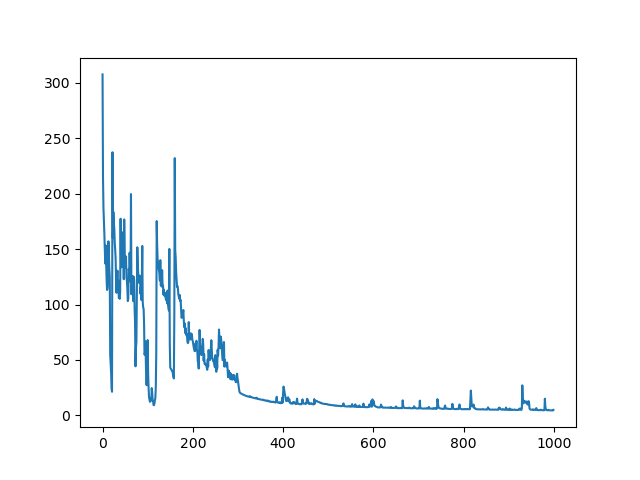

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_sequence)
plt.show()

In [14]:
import matplotlib.pyplot as plt

predictions = []
targets = []
with torch.no_grad():
	for data in train_data:
			input_data = torch.from_numpy(data[0]).float().to(device)
			target_pred = torch.tensor(data[1]).unsqueeze(0)
			output = torch.sigmoid(model(input_data)[-1])
			predictions.append(output.cpu().item())
			targets.append(target_pred.item())

pred = np.array(predictions)
pred = np.rint(pred).astype(int)
targets_numpy = np.array(targets)

print(np.sum(np.abs(targets_numpy-pred)))
print(np.sum(targets_numpy))
print(np.sum(pred))

2
290
288


In [15]:
# Evaluate on the test dataset
model.eval()

predictions = []
targets = []
with torch.no_grad():
	for data in test_data:
			input_data = torch.from_numpy(data[0]).float().to(device)
			target_pred = torch.tensor(data[1]).unsqueeze(0)
			output = torch.sigmoid(model(input_data)[-1])
			predictions.append(output.cpu().item())
			targets.append(target_pred.item())

pred = np.array(predictions)
pred = np.rint(pred).astype(int)
targets_numpy = np.array(targets)

print(np.sum(np.abs(targets_numpy-pred)))
print(np.sum(pred))
print(np.sum(targets_numpy))

# print(np.where(test_targets != pred))
# print(np.where(np.abs(test_targets-pred) != 0))

8
31
33


In [8]:
print(len(test_data))

66
